<a href="https://colab.research.google.com/github/kKn00077/techit-travel-data-analysis/blob/main/China_Douyin_Txtmining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 필요한 모듈 인스톨
# !pip install konlpy
# !pip install gdown

In [27]:
# 필요한 모듈 임포트
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
import re

In [35]:
import gdown

# 스프레드시트 ID
file_id = '1v_ATNrRUvX6VX_9bhzMuVBr89jsB05-umqP2R43QKOY'

# CSV 다운로드 링크 생성
download_url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv"

# 다운로드 파일명 지정
output = '241112_Douyin_Search_KorTour.csv'

# 파일 다운로드
gdown.download(download_url, output, quiet=False)

df = pd.read_csv(output)
display(df.head(), df.shape)

Downloading...
From: https://docs.google.com/spreadsheets/d/1v_ATNrRUvX6VX_9bhzMuVBr89jsB05-umqP2R43QKOY/export?format=csv
To: /content/241112_Douyin_Search_KorTour.csv
901kB [00:00, 10.1MB/s]


,no,keyword,runtime,like,title,title_ko,channel,date
0,1,한국여행,5:17,7948,终于有人把首尔讲清楚了！ 韩国首尔四天三夜保姆级攻略~ #首尔 #韩国 #旅行,드디어 누군가 서울을 제대로 알려줬어요! 3박 4일 동안의 대한민국 서울 여행~ #...,@Linlin的奇妙冒险,2024-11-05
1,2,한국여행,5:40,130000,韩国皇宫，小小的也很可爱！ #韩国 #景福宫 #韩国旅缩力 #旅缩力,작고 귀여운 한국의 왕궁! 한국 #경복궁 #한국여행 #여행의힘 #여행의힘,@马佳matta,2024-11-05
2,3,한국여행,8:08,14000,把P人逼成J人的超详细首尔攻略！！！看完还不会玩的我带你去🙂#国庆 #韩国旅行 #vlog ...,P족을 J족으로 만드는 초특급 서울 가이드!!!! 이 글을 읽고도 재미없으시다면 제...,@心想是陈奶酪Ya(卷土重来版),2024-09-28
3,4,한국여행,0,168,📍韩国 自由小团，说走就走🏃。☑️甄选特色美食：人参鸡、石锅拌饭、烤肉、炸酱面.... ☑️...,"한국 무료 소그룹, 그냥 가자 🏃. ☑️ 선정 특선 음식: 인삼닭, 돌솥비빔밥, 바...",@国旅优景旅行,2024-09-03
4,5,한국여행,19:19,5293,中国小伙闲逛首尔明洞 垃圾遍地 美女如云 彻底刷新认知 #我被旅行治愈了 #铁腚旅行 #鸣潮...,"서울 명동 돌아다니는 중국인 남자, 사방에 쓰레기, 아름다운 여자, 완전히 상쾌한 ...",@野原新之助天下第一,2024-09-23


(1386, 8)

In [36]:
# 전처리(1) : 이모티콘, 특수문자 제거

import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

okt = Okt()

# 이모티콘, 특수문자 제거
def preprocess(text):
    # 이모티콘, 유니코드 범위 및 특수 문자를 제거하는 정규식 (숫자는 제외)
    emoji_pattern = re.compile(
        r"["
        r"\U0001F600-\U0001F64F"  # 이모티콘 범위 (유니코드)
        r"\U0001F300-\U0001F5FF"  # 기호 및 아이콘
        r"\U0001F680-\U0001F6FF"  # 운송 및 기계 관련 유니코드
        r"\U0001F700-\U0001F77F"  # 기타 유니코드 기호
        r"\U0001F780-\U0001F7FF"  # 추가 유니코드 기호
        r"\U0001F800-\U0001F8FF"  # 유니코드 기술 문자
        r"\U0001F900-\U0001F9FF"  # 제스처와 감정 관련 이모티콘
        r"\U0001FA00-\U0001FA6F"  # 이모티콘 확장
        r"\U0001FB00-\U0001FBFF"  # 추가 확장 이모티콘
        r"\u2600-\u26FF"          # 기호 및 도형 (예: ♠, ♣)
        r"\u2700-\u27BF"          # 기타 기호 (예: ✨, ✋)
        r"]+",
        flags=re.UNICODE
    )

    # 정규식을 이용해 매칭되는 문자 제거
    return emoji_pattern.sub(r'', str(text))

# 모든 텍스트에 대해 전처리 적용
df['processed_title_ko'] = df['title_ko'].apply(preprocess)

In [37]:
# 전처리(2) : 유사 단어 치환, 명사, 용언 추출, 불용어 처리

# 유사 단어 치환
replace_dict = {
    "서울특별시": "서울",
    "수도" : "서울",
    "부산광역시": "부산",
    "경기도" : "경기",
    "제주도": "제주",
    "강원도" : "강원",
    "인천광역시" : "인천"
    # 필요한 만큼 추가
}

# 텍스트 전처리 및 명사, 용언 추출 함수 정의
def preprocess_text(text):
    # NaN이나 float 값을 처리하기 위해 문자열로 변환
    if isinstance(text, float):
        return []

    # 형태소 분석
    pos = okt.pos(text, norm=True, stem=True)

    # 명사와 용언만 필터링
    result = []

    for word, tag in pos:
        if word in replace_dict :
          word = replace_dict[word]

        if tag == 'Noun' and len(word) > 1:  # 명사
            result.append(word)

        elif tag in ['Verb', 'Adjective']:   # 용언(동사, 형용사)
            if not word.endswith('다'):      # 이미 "다"로 끝나지 않으면 추가
                word += '다'
            result.append(word)

    return result

# 모든 텍스트 데이터를 하나로 결합 후, 명사 및 용언 추출
all_words = []
for text in df['processed_title_ko']:  # 'processed_title_ko'는 텍스트가 포함된 컬럼 이름
    all_words.extend(preprocess_text(text))

# 단어 빈도 계산
word_counts = Counter(all_words)

# 데이터프레임으로 변환
df_word = pd.DataFrame(word_counts.items(), columns=['word', 'freq'])

# 불용어 처리
stop_words = ["가다", "이다", "오다", "하다", "보다", "만들다", "없다", "있다", "되어다", "가보다",
              "아니다", "않다", "되다", "같다", "알다", "모르다", "생각", "싶다", "나오다",
              "보이다", "이렇다", "많다", "그렇다", "진짜", "정말", "가장", "정도",  "매우",
              "한국", "대한민국", "여행", "한국여행", "브이", "로그", "마을", "추천", "명소", "투어", "관광", "가이드"]  # 커스텀 불용어 리스트
df_word = df_word[~df_word['word'].isin(stop_words)]

# 상위 50개 단어를 빈도순으로 정렬하여 출력
df_word_sorted = df_word.sort_values(by='freq', ascending=False).reset_index(drop=True)
df_word_sorted.head(50)

,word,freq
0,서울,524
1,부산,458
2,제주,419
3,좋다,244
4,인천,233
5,아름답다,211
6,문화,159
7,경기,145
8,바다,142
9,즐기다,130


In [26]:
# 구글 코렙에서 워드클라우드를 위한 폰트 설치
!sudo apt-get install -y fonts-noto-cjk

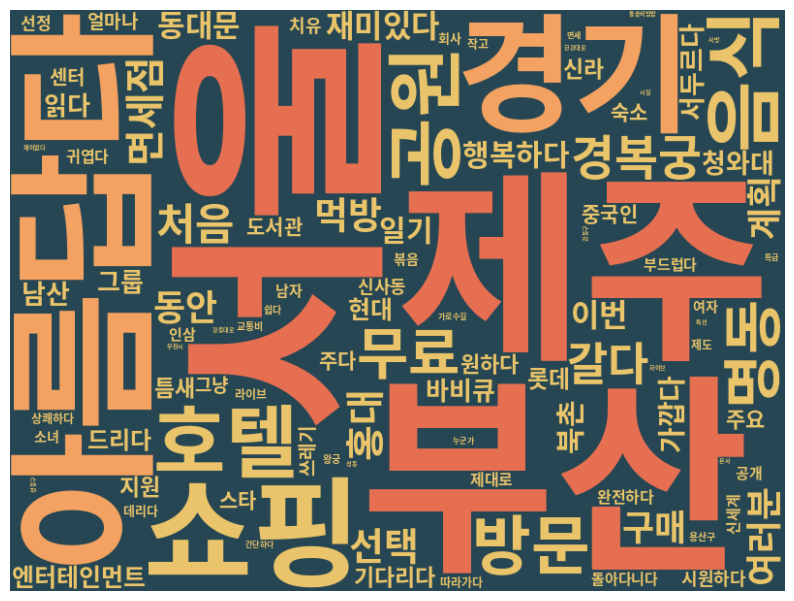

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 (코랩에서 설치한 경우)
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'

# 상위 100개 데이터 사용
top_words = df_word.head(100)

# 빈도에 따른 색상 설정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    freq = df_word.set_index('word').at[word, 'freq'] / df_word['freq'].sum()
    if freq > 0.01:
        return '#e76f51'
    elif freq > 0.005:
        return '#f4a261'
    else:
        return '#e9c46a'

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,          # 한글 폰트 경로 설정
    background_color='#264653',  # 배경색
    width=800,
    height=600,
    min_font_size=4,             # 최소 글자 크기
    color_func=color_func        # 색상 함수
).generate_from_frequencies(dict(top_words.values))

# 워드클라우드 출력
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()